In [17]:
%reset -sf

import pandas as pd
import numpy as np
import get_data as gd
import atlas_plot as ap
import gc

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)
print(tf.config.list_physical_devices())
print()

2.13.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]



In [18]:
np.random.seed(42)  # set random seed
sampling = int(1e5)
processor = gd.DataProcessor(sampling=sampling)
path = "/root/work/truth/signal/*npz"
processor.load_files(path)
data = gd.Data(*processor.files)
# print(dir(data))

['/root/work/truth/signal/CGLMP.npz', '/root/work/truth/signal/Higgs.npz', '/root/work/truth/signal/LeadLepton.npz', '/root/work/truth/signal/LeptonM.npz', '/root/work/truth/signal/LeptonP.npz', '/root/work/truth/signal/LmNu.npz', '/root/work/truth/signal/LpNu.npz', '/root/work/truth/signal/MET.npz', '/root/work/truth/signal/WmBoson.npz', '/root/work/truth/signal/WpBoson.npz', '/root/work/truth/signal/diLepton.npz', '/root/work/truth/signal/subLeadLepton.npz', '/root/work/truth/signal/xi_xyz.npz']



In [19]:
GEV = 1e3

cut_pre_pt_lead = data.LeadLep["pt"] > 22 * GEV
cut_pre_pt_sub = data.SubLep["pt"] > 15 * GEV
cut_pre_dilep_m = data.diLep["m"] > 10 * GEV
cut_pre_pt_miss = data.MET["pt"] > 20 * GEV
cut_pre = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss

del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)

In [20]:
# y -> observed params
lep_p = processor.process_part(data.LepP)[cut_pre]
lep_m = processor.process_part(data.LepM)[cut_pre]
lep_kin = pd.concat([lep_p, lep_m], axis=1)
MET = processor.process_MET(data.MET).iloc[:, 1:3][cut_pre]
MET_kin = pd.concat([MET, lep_kin], axis=1)
print("MET_kin shape:", MET_kin.shape)
print(MET_kin.head(3))
print()

# x -> interested unknowns
dinu_kin = pd.DataFrame(processor.process_dipart(data.LepP, data.LepM)["E"][cut_pre])
print("dinu_kin shape:", dinu_kin.shape)
print(dinu_kin.head(3))
print()

del (processor, lep_p, lep_m, MET)
gc.collect()

MET_kin shape: (46543, 10)
      MET_px     MET_py          E         px         py          pz  \
1  49.089071  35.247486  34.924703 -22.984227  38.974219  240.084062   
2 -39.683460 -39.809454  29.821395   0.294616  39.725855  -57.373270   
3 -12.730163 -26.521621  58.933641  24.955598 -15.576824  -21.163869   

           E         px         py          pz  
1  34.224207  13.064576  20.918969   86.253117  
2  31.485041  13.998392 -23.331045 -169.804609  
3  22.611654   7.378456  17.052838 -106.930852  

dinu_kin shape: (46543, 1)
           E
1  69.148910
2  61.306436
3  81.545295



15067

In [21]:
from sklearn.preprocessing import StandardScaler

SCALAR_int = StandardScaler()
norm_var = SCALAR_int.fit_transform(dinu_kin)
dinu_kin = norm_var

SCALAR_MET = StandardScaler()
norm_var = SCALAR_MET.fit_transform(MET_kin)
MET_kin = norm_var

del norm_var

from sklearn.model_selection import train_test_split

indices_arr = np.arange(dinu_kin.shape[0], dtype="int")
indices_arr = np.random.choice(indices_arr, sampling)
train_indices, temp_indices = train_test_split(
    indices_arr.flatten(), train_size=0.8, test_size=0.2, random_state=42
)
valid_indices, test_indices = train_test_split(
    temp_indices, train_size=0.5, test_size=0.5, random_state=42
)

train_x = dinu_kin[train_indices]
valid_x = dinu_kin[valid_indices]
test_x = dinu_kin[test_indices]
train_y = MET_kin[train_indices]
valid_y = MET_kin[valid_indices]
test_y = MET_kin[test_indices]

print(
    f"X (Interest)\nTraining data shape: {train_x.shape};\nValiding data shape: {valid_x.shape};\nTesting data shape: {test_x.shape}."
)
print(
    f"Y (Observed)\nTraining data shape: {train_y.shape};\nValiding data shape: {valid_y.shape};\nTesting data shape: {test_y.shape}."
)
print()

X (Interest)
Training data shape: (80000, 1);
Validing data shape: (10000, 1);
Testing data shape: (10000, 1).
Y (Observed)
Training data shape: (80000, 10);
Validing data shape: (10000, 10);
Testing data shape: (10000, 10).



In [22]:
def build_model():
    model = keras.models.Sequential()

    # encoder
    model.add(layers.Flatten(input_shape=(train_y.shape[-1],)))
    model.add(layers.Dense(units=8, activation="relu"))
    model.add(layers.Dense(units=4, activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    # bottleneck
    model.add(layers.Dense(units=2, activation="relu"))
    # decoder
    model.add(layers.Dense(units=4, activation="relu"))
    model.add(layers.Dense(units=8, activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # Last dense layers
    model.add(layers.Dense(units=1, activation="linear"))

    # Compile model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss="mse")
    model.summary()

    return model

In [23]:
model = build_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 10)                0         
                                                                 
 dense_6 (Dense)             (None, 8)                 88        
                                                                 
 dense_7 (Dense)             (None, 4)                 36        
                                                                 
 batch_normalization_2 (Bat  (None, 4)                 16        
 chNormalization)                                                
                                                                 
 re_lu_2 (ReLU)              (None, 4)                 0         
                                                                 
 dense_8 (Dense)             (None, 2)                 10        
                                                      

In [24]:
# Load the TensorBoard notebook extension.
import datetime

# set log file
%rm -r ./logs
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# set callback of tensorboard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=5, write_graph=True, write_images=False,)

stop_early = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-6,
    patience=10,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

# Fit the model
history = model.fit(
    x=train_y,
    y=train_x,
    validation_data=(valid_y, valid_x),
    epochs=512,
    batch_size=128,
    verbose=2,
    callbacks=[stop_early, tensorboard_callback],
)

Epoch 1/512
625/625 - 5s - loss: 1.3480 - val_loss: 1.1639 - 5s/epoch - 8ms/step
Epoch 2/512
625/625 - 3s - loss: 1.0658 - val_loss: 0.9702 - 3s/epoch - 5ms/step
Epoch 3/512
625/625 - 3s - loss: 0.9563 - val_loss: 0.9049 - 3s/epoch - 4ms/step
Epoch 4/512
625/625 - 3s - loss: 0.9050 - val_loss: 0.8660 - 3s/epoch - 4ms/step
Epoch 5/512
625/625 - 3s - loss: 0.8673 - val_loss: 0.8304 - 3s/epoch - 4ms/step
Epoch 6/512
625/625 - 3s - loss: 0.8330 - val_loss: 0.7938 - 3s/epoch - 4ms/step
Epoch 7/512
625/625 - 3s - loss: 0.7986 - val_loss: 0.7588 - 3s/epoch - 4ms/step
Epoch 8/512
625/625 - 3s - loss: 0.7606 - val_loss: 0.7191 - 3s/epoch - 4ms/step
Epoch 9/512
625/625 - 3s - loss: 0.7242 - val_loss: 0.6849 - 3s/epoch - 4ms/step
Epoch 10/512
625/625 - 3s - loss: 0.6911 - val_loss: 0.6539 - 3s/epoch - 4ms/step
Epoch 11/512
625/625 - 3s - loss: 0.6632 - val_loss: 0.6280 - 3s/epoch - 4ms/step
Epoch 12/512
625/625 - 3s - loss: 0.6387 - val_loss: 0.6067 - 3s/epoch - 4ms/step
Epoch 13/512
625/625 - 3s

In [25]:
x_pred = model.predict(test_y)
sig_pred = x_pred.flatten()
sig_truth = test_x.flatten()

313/313 [==============================] - 1s 1ms/step


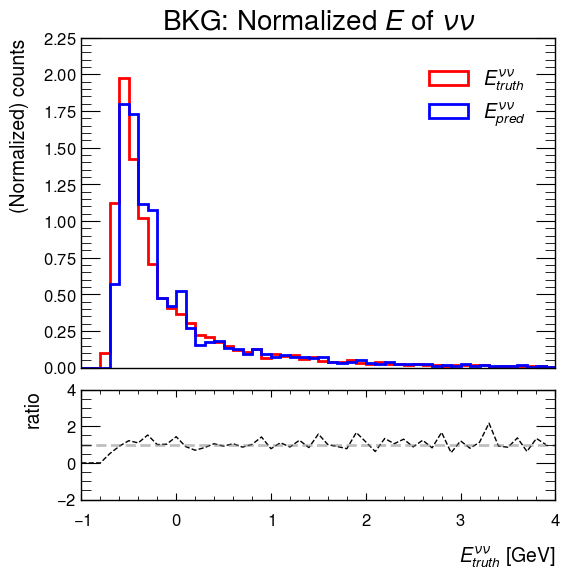

<Figure size 800x600 with 0 Axes>

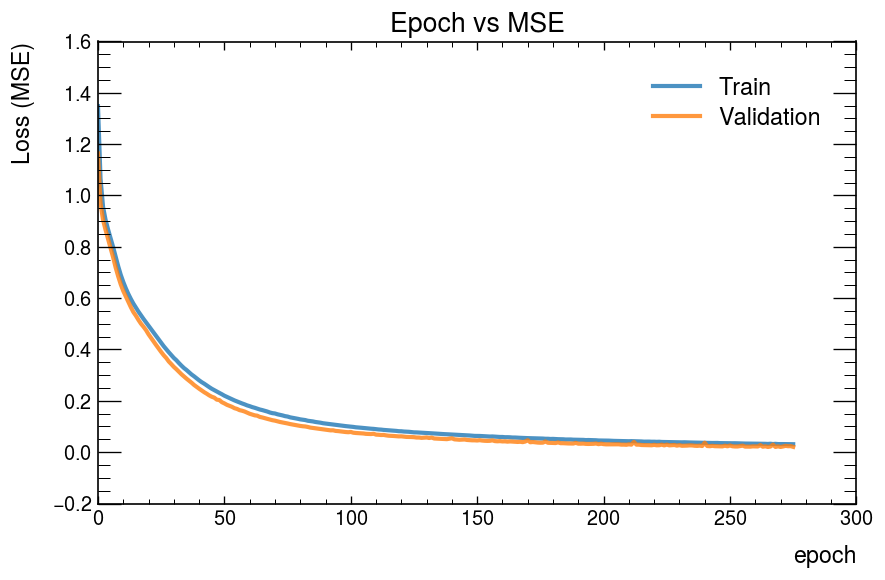

<Figure size 800x600 with 0 Axes>

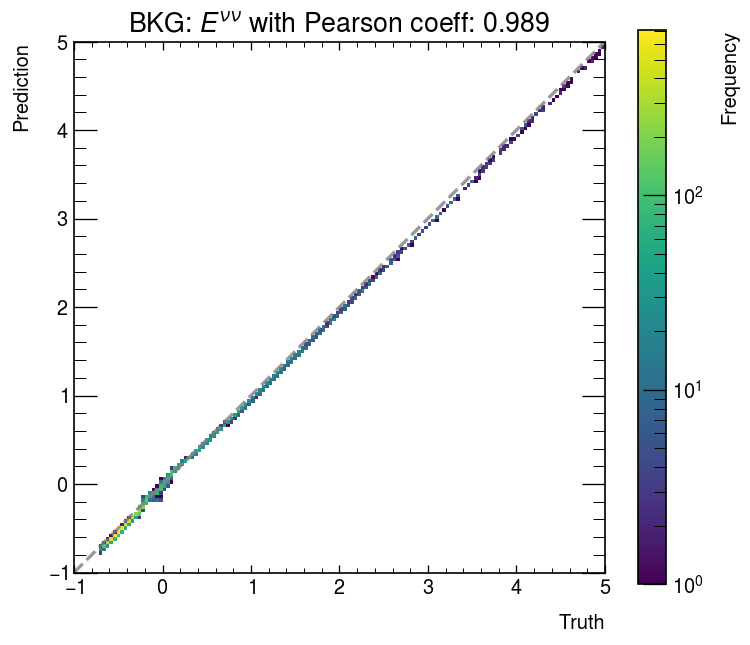

<Figure size 800x600 with 0 Axes>

In [26]:
import scipy as sp

plot = ap.Plotter()

plot.plot_hist(
    [sig_truth, sig_pred],
    [r"$E_{truth}^{\nu\nu}$", r"$E_{pred}^{\nu\nu}$"],
    "BKG: " + r"Normalized $E$ of $\nu\nu$",
    [-1, 4],
)
plot.plot_loss_history(history)

plot.plot_2d_histogram(
    sig_pred,
    sig_truth,
    "BKG: "
    + r"$E^{\nu\nu}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth, sig_pred)[0]:.3f}",
    range=[-1, 5],
)

In [27]:
# Background

processor = gd.DataProcessor(sampling=sampling)
path = "/root/work/truth/background/*npz"
processor.load_files(path)
data = gd.Data(*processor.files)
# print(dir(data))

['/root/work/truth/background/CGLMP.npz', '/root/work/truth/background/Higgs.npz', '/root/work/truth/background/LeadLepton.npz', '/root/work/truth/background/LeptonM.npz', '/root/work/truth/background/LeptonP.npz', '/root/work/truth/background/LmNu.npz', '/root/work/truth/background/LpNu.npz', '/root/work/truth/background/MET.npz', '/root/work/truth/background/WmBoson.npz', '/root/work/truth/background/WpBoson.npz', '/root/work/truth/background/diLepton.npz', '/root/work/truth/background/subLeadLepton.npz', '/root/work/truth/background/xi_xyz.npz']



In [28]:
GEV = 1e3

cut_pre_pt_lead = data.LeadLep["pt"] > 22 * GEV
cut_pre_pt_sub = data.SubLep["pt"] > 15 * GEV
cut_pre_dilep_m = data.diLep["m"] > 10 * GEV
cut_pre_pt_miss = data.MET["pt"] > 20 * GEV
cut_pre = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss

del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)

In [29]:
# y -> observed params
lep_p = processor.process_part(data.LepP)[cut_pre]
lep_m = processor.process_part(data.LepM)[cut_pre]
lep_kin = pd.concat([lep_p, lep_m], axis=1)
MET = processor.process_MET(data.MET).iloc[:, 1:3][cut_pre]
MET_kin = pd.concat([MET, lep_kin], axis=1)
print("MET_kin shape:", MET_kin.shape)
print(MET_kin.head(3))
print()

# x -> interested unknowns
dinu_kin = pd.DataFrame(processor.process_dipart(data.LepP, data.LepM)["E"][cut_pre])
print("dinu_kin shape:", dinu_kin.shape)
print(dinu_kin.head(3))
print()

del (processor, lep_p, lep_m, MET)
gc.collect()

MET_kin shape: (67474, 10)
      MET_px     MET_py           E         px         py          pz  \
0  10.249510 -57.160299  177.182906 -45.892637  48.791598    4.952505   
1  -9.130350  50.000687   59.324352  59.150137 -11.705640  170.388703   
4  49.052965  28.857007    8.479149  42.503437  -3.036340  813.755000   

            E         px         py          pz  
0  626.035437  27.727525 -27.620148   48.518027  
1   25.818158 -39.502258 -38.285684  -17.901195  
4   37.684832 -56.535414   2.727209  647.209625  

dinu_kin shape: (67474, 1)
            E
0  803.218344
1   85.142510
4   46.163981



33043

In [30]:
SCALAR_int_bkg = StandardScaler()
norm_var = SCALAR_int.fit_transform(dinu_kin)
dinu_kin = norm_var

SCALAR_MET_bkg = StandardScaler()
norm_var = SCALAR_MET.fit_transform(MET_kin)
MET_kin = norm_var

del norm_var

x, y = dinu_kin[test_indices], MET_kin[test_indices]

print(f"X (Interest) data shape: {x.shape};\nY (Observed) data shape: {y.shape}.")
print()

X (Interest) data shape: (10000, 1);
Y (Observed) data shape: (10000, 10).



In [31]:
x_pred = model.predict(y)
bkg_pred = x_pred.flatten()
bkg_truth = x.flatten()

  1/313 [..............................] - ETA: 7s

313/313 [==============================] - 0s 1ms/step


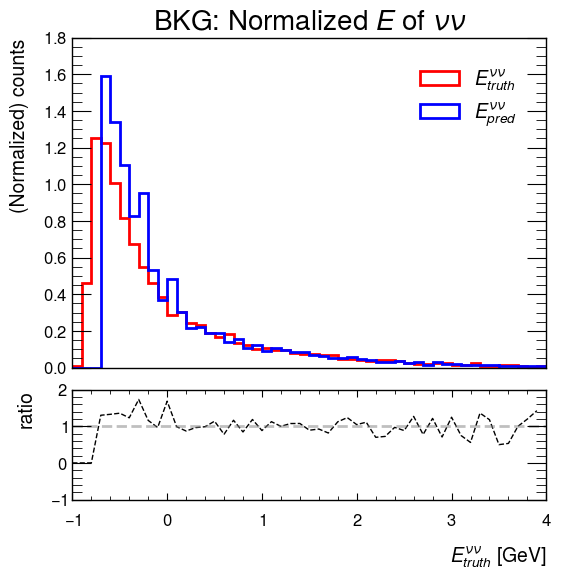

<Figure size 800x600 with 0 Axes>

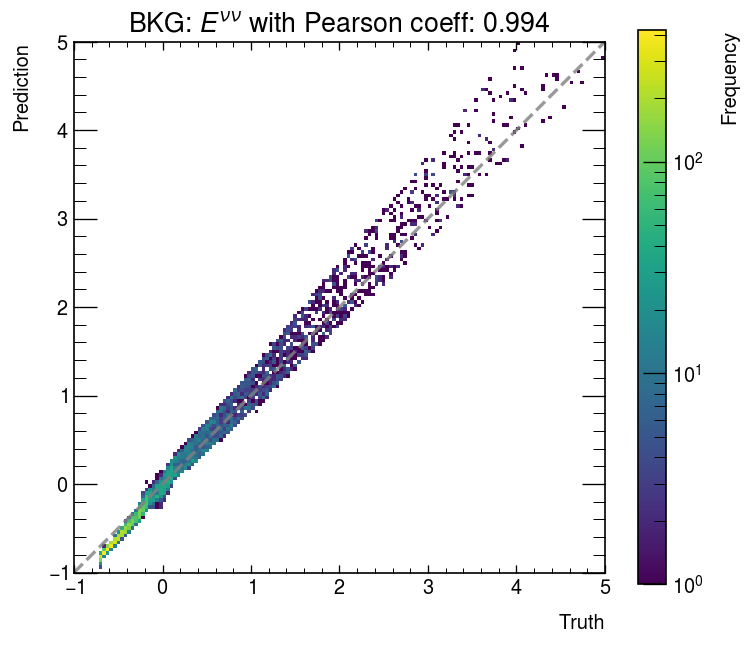

<Figure size 800x600 with 0 Axes>

In [32]:
plot = ap.Plotter()

plot.plot_hist(
    [bkg_truth, bkg_pred],
    [r"$E_{truth}^{\nu\nu}$", r"$E_{pred}^{\nu\nu}$"],
    "BKG: " + r"Normalized $E$ of $\nu\nu$",
    [-1, 4],
)

plot.plot_2d_histogram(
    bkg_pred,
    bkg_truth,
    "BKG: "
    + r"$E^{\nu\nu}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(bkg_truth, bkg_pred)[0]:.3f}",
    range=[-1, 5],
)